# Image Processing CookBook
## Chapter 09
### Author: Sandipan Dey

### Facial Landmark Detection and Snapchat-like Selfie Filters

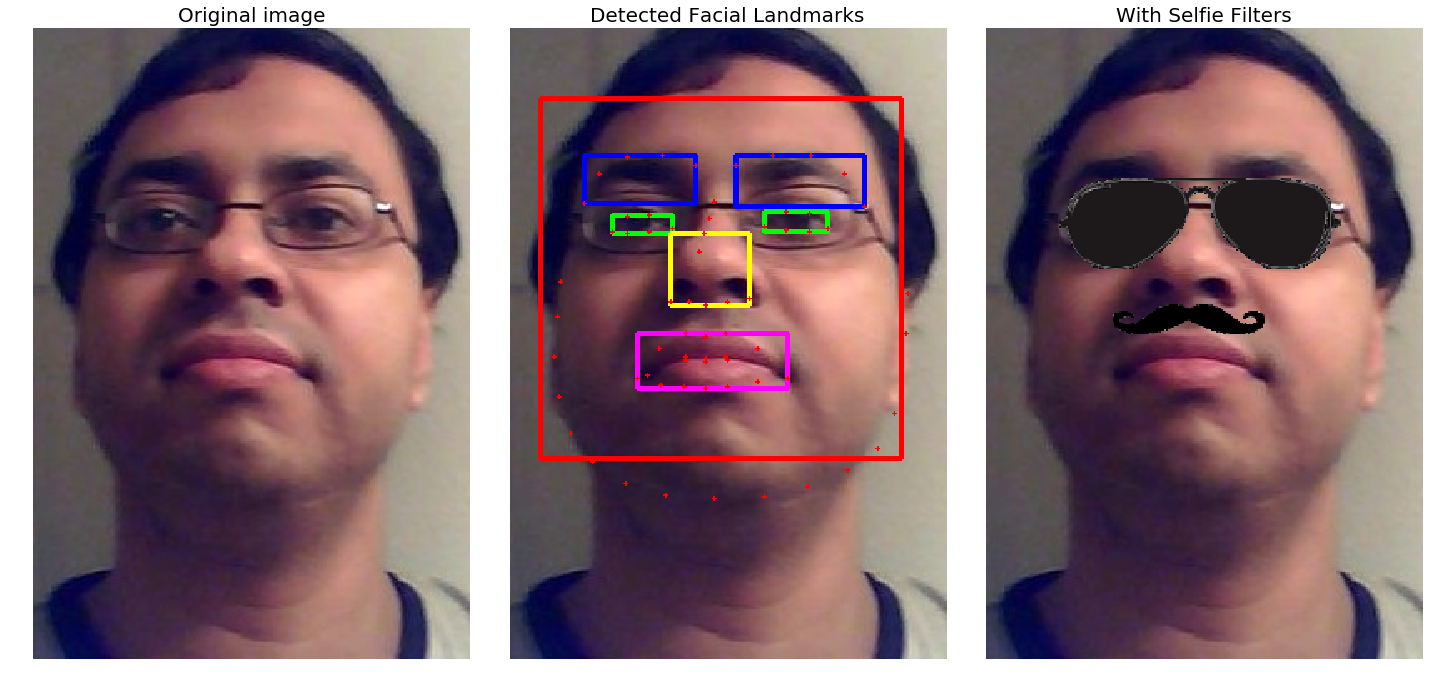

In [85]:
% matplotlib inline
from PIL import Image
import numpy as np
import dlib
import cv2
from imutils import face_utils, rotate_bound
import matplotlib.pylab as plt

# download model from: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 and uncompress
model = "models/shape_predictor_68_face_landmarks.dat" 
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model) 

def calculate_boundbox(list_coordinates):
    x = min(list_coordinates[:,0])
    y = min(list_coordinates[:,1])
    w = max(list_coordinates[:,0]) - x
    h = max(list_coordinates[:,1]) - y
    return (x,y,w,h)

def get_face_boundbox(points, face_part):
    if face_part == 1:
        (x,y,w,h) = calculate_boundbox(points[17:22]) #left eyebrow
    elif face_part == 2:
        (x,y,w,h) = calculate_boundbox(points[22:27]) #right eyebrow
    elif face_part == 3:
        (x,y,w,h) = calculate_boundbox(points[36:42]) #left eye
    elif face_part == 4:
        (x,y,w,h) = calculate_boundbox(points[42:48]) #right eye
    elif face_part == 5:
        (x,y,w,h) = calculate_boundbox(points[29:36]) #nose
    elif face_part == 6:
        (x,y,w,h) = calculate_boundbox(points[48:68]) #mouth
    return (x,y,w,h)

colors = [(0, 0, 0), (255, 0, 0), (255, 0, 0), (0, 255, 0), (0, 255, 0), (0, 255, 255), (255, 0, 255)]
orig = cv2.imread('images/me.jpg')
image = orig.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# detect faces in the grayscale frame
rects = detector(gray, 0)
# loop over the face detections
for rect in rects:
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    for i in range(1,7):
        (x,y,w,h) = get_face_boundbox(shape, i)
        cv2.rectangle(image, (x, y), (x+w, y+h), colors[i], 2)
    x,y, w, h = rect.left(), rect.top(), rect.width(), rect.height()
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

plt.figure(figsize=(20,10))
plt.subplot(131), plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('Original image', size=20)
plt.subplot(132), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('Detected Facial Landmarks', size=20)
    
image = orig    
(x_start,y_start,_,h) = calculate_boundbox(shape[17:22]) #left eyebrow
y_start = y_start + h//2
(x_end,_,w,_) = calculate_boundbox(shape[22:27]) #right eyebrow
x_end = x_end + w
(_,y_end,_,h) = calculate_boundbox(shape[29:36]) #nose
y_end = y_end + h//2    
mask = cv2.imread('images/sunglass.png',cv2.IMREAD_UNCHANGED)
temp = cv2.resize(mask,(x_end-x_start+1,y_end-y_start+1))
for i in range(y_start,y_end+1):
    for j in range(x_start,x_end+1):
        if temp[i-y_start,j-x_start,3] != 0:
            image[i,j,:] = temp[i-y_start,j-x_start,:3]
            
(_,y_start,_,h) = calculate_boundbox(shape[29:36]) #nose
(x_start,y_end,w,_) = calculate_boundbox(shape[48:68]) #mouth
y_start, x_end = y_start + h, x_start + w  
mask = cv2.imread('images/mustache.png',cv2.IMREAD_UNCHANGED)
temp = cv2.resize(mask,(x_end-x_start+1,y_end-y_start+1))
for i in range(y_start,y_end+1):
    for j in range(x_start,x_end+1):
        if temp[i-y_start,j-x_start,3] != 0:
            image[i,j,:] = temp[i-y_start,j-x_start,:3]
            
plt.subplot(133), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('With Selfie Filters', size=20)
plt.tight_layout()
plt.show()

### Deep Learning for Face Detection with FaceNet (Keras)

In [1]:
#https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
# googleimagesdownload --keywords "Euler" --limit 20
%matplotlib inline
#from keras.models import load_model
from tensorflow.keras.models import load_model
#!pip install mtcnn
import mtcnn
# print version
print(mtcnn.__version__)
from mtcnn.mtcnn import MTCNN
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
import numpy as np
import matplotlib.pylab as plt
import os

Using TensorFlow backend.


0.1.0


In [2]:
# https://stackoverflow.com/questions/47068709/your-cpu-supports-instructions-that-this-tensorflow-binary-was-not-compiled-to-u
# example of loading the keras facenet model
# https://drive.google.com/drive/folders/12aMYASGCKvDdkygSv1yQq8ns03AStDO_
# load the model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
model = load_model('models/facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/Identity:0' shape=(None, 128) dtype=float32>]


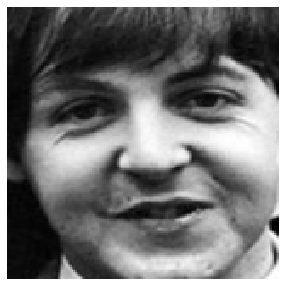

In [3]:
# extract a single face from a given photograph
def extract_face(image_file, required_size=(160, 160)):
    # load image from file
    image = imread(image_file)
    #print(image_file, image.shape)
    if len(image.shape) < 3: image = gray2rgb(image) 
    else: image = image[...,:3]
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(image)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = image[y1:y2, x1:x2]
    # resize pixels to the model size
    return resize(face, required_size)

face = extract_face('images/beatles.png')
plt.figure(figsize=(5,5))
plt.imshow(face), plt.axis('off')
plt.show()

In [4]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    #i = 1
    for filename in os.listdir(directory):
        # path
        path = directory + filename
        #new_path = directory + str(i) + filename[-4:]
        #os.rename(path, new_path)
        # get face
        face = extract_face(path)
        print(path, face.shape)
        # store
        faces.append(face)
        #i += 1
    return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = [], []
    # enumerate folders, on per class
    for subdir in os.listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
        #print('extended')  
    #X, y = np.concatenate(X, axis=0), np.array(y)
    return np.array(X), np.array(y)

# load train dataset
#X_train, y_train = load_dataset('images/5-celebrity-faces-dataset/train/')
X_train, y_train = load_dataset('images/mathematicians/train/')
print(X_train.shape, y_train.shape)
# load test dataset
#X_test, y_test = load_dataset('images/5-celebrity-faces-dataset/val/')
X_test, y_test = load_dataset('images/mathematicians/val/')
print(X_test.shape, y_test.shape)
# save arrays to one file in compressed format
#np.savez_compressed('images/5-celebrity-faces-dataset.npz', X_train, y_train, X_test, y_test)
np.savez_compressed('images/6-mathematicians.npz', X_train, y_train, X_test, y_test)

images/mathematicians/train/Bayes+Thomas/1.225px-Thomas_Bayes.jpg (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/10.Thomas-Bayes-trying-to-decide-the-value-of-a-coins-bias_Q320.jpg (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/12.Thomas-Bayes-trying-to-decide-the-value-of-a-coins-bias.png (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/13.thomas-bayes-t-shirt-for-all-the-fans-of-bayesian-statistics-and-machine-learning.jpg (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/2.Thomas_Bayes3.jpg (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/3.bayes.jpg (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/4._55009536_55001095.jpg (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/5.lead_720_405.jpg (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/6.Thomas_Bayes.png (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/7.Thomas-Bayes.png (160, 160, 3)
images/mathematicians/train/Bayes+Thomas/8.MTIyMzI2MjkwNDMzOTk5NDYy.png (160, 160, 3)
>load

images/mathematicians/val/Markov+Andrey/14.portrait%5E.jpg (160, 160, 3)
images/mathematicians/val/Markov+Andrey/15.maxresdefault.jpg (160, 160, 3)
images/mathematicians/val/Markov+Andrey/17.Stochastic-perspective-a-Andrey-Markov-developed-the-Markov-chain-theory-b-A-single.png (160, 160, 3)
images/mathematicians/val/Markov+Andrey/18.andrey-markov-jr-b124636d-4c15-44b0-8c8b-236c41adf82-resize-750.jpeg (160, 160, 3)
images/mathematicians/val/Markov+Andrey/19.015391747_1-b75351cbd414a562ec1ec7a2eab49d93.png (160, 160, 3)
>loaded 5 examples for class: Markov+Andrey
images/mathematicians/val/Turing/14.f86fc26c86b444c391fb412bb3dcec76-articleLarge.jpg (160, 160, 3)
images/mathematicians/val/Turing/15.alan_turing.jpg (160, 160, 3)
images/mathematicians/val/Turing/16.v3-Turing-Benedict-Cumberbatch.jpg (160, 160, 3)
images/mathematicians/val/Turing/17.00overlooked-alanturing-3-facebookJumbo.jpg (160, 160, 3)
images/mathematicians/val/Turing/18.alan_turing2.jpg (160, 160, 3)
images/mathematicia

(72, 160, 160, 3)


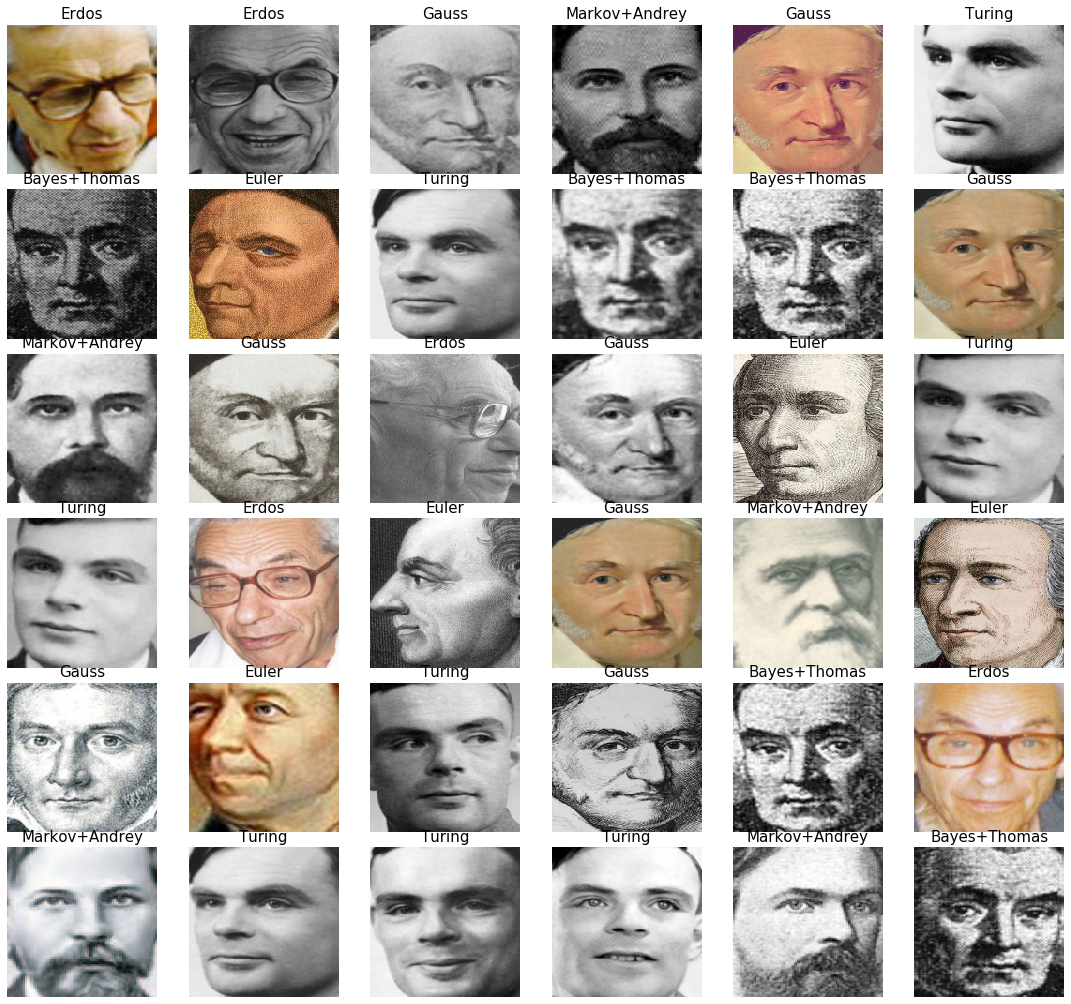

In [17]:
data = np.load('images/6-mathematicians.npz')
X_train, y_train, X_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(X_train.shape)
indices = np.random.choice(X_train.shape[0], 36, replace=False)
plt.figure(figsize=(15,15))
plt.subplots_adjust(0,0,1,0.9,0.05,0.1)
for i in range(len(indices)):
    plt.subplot(6,6,i+1), plt.imshow(X_train[indices[i]]), plt.axis('off'), plt.title(y_train[indices[i]], size=15)
plt.show()

In [5]:
# get the face embedding for one face
def get_embedding(model, faces):
    # scale pixel values
    faces = faces.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = faces.mean(), faces.std()
    faces = (faces - mean) / std
    # transform face into one sample
    samples = np.expand_dims(faces, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

# load the face dataset
#data = np.load('images/5-celebrity-faces-dataset.npz')
data = np.load('images/6-mathematicians.npz')
X_train, y_train, X_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# convert each face in the train set to an embedding
X_train_em = []
for faces in X_train:
    #print(faces.shape)
    embedding = get_embedding(model, faces)
    X_train_em.append(embedding)
X_train_em = np.asarray(X_train_em)
print(X_train_em.shape)
# convert each face in the test set to an embedding
X_test_em = []
for faces in X_test:
    embedding = get_embedding(model, faces)
    X_test_em.append(embedding)
X_test_em = np.asarray(X_test_em)
print(X_test_em.shape)
# save arrays to one file in compressed format
#np.savez_compressed('models/5-celebrity-faces-embeddings.npz', X_train_em, y_train, X_test_em, y_test)
np.savez_compressed('models/6-mathematicians-embeddings.npz', X_train_em, y_train, X_test_em, y_test)

Loaded:  (72, 160, 160, 3) (72,) (36, 160, 160, 3) (36,)
(72, 128)
(36, 128)


In [6]:
#data = np.load('models/5-celebrity-faces-embeddings.npz')
data = np.load('models/6-mathematicians-embeddings.npz')
X_train, y_train, X_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (X_train.shape[0], X_test.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
X_train = in_encoder.transform(X_train)
X_test = in_encoder.transform(X_test)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)
# predict
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)
# score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=72, test=36
Accuracy: train=100.000, test=94.444


Predicted: Bayes+Thomas (80.349)
Expected: Bayes+Thomas


C:\Users\Sandipan.Dey\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


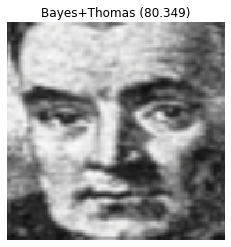

In [7]:
data = np.load('images/6-mathematicians.npz')
X_test_faces = data['arr_2']
# test model on a random example from the test dataset
selection = np.random.choice(X_test.shape[0], 1)
random_face_pixels = X_test_faces[selection]
random_face_emb = X_test[selection]
random_face_class = y_test[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
yhat_class = model.predict(random_face_emb)
yhat_prob = model.predict_proba(random_face_emb)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
plt.imshow(random_face_pixels[0]), plt.title('%s (%.3f)' % (predict_names[0], class_probability)), plt.axis('off')
plt.show()

In [ ]:
#from sklearn.metrics import classification_report
#import keras
#y_hat_classes = keras.utils.np_utils.to_categorical(yhat_test)
#print(classification_report(y_test, y_hat_classes))#, target_names=target_names))

### Deep Learning for Emotion/Gender Recognition

[39.10512129]
[45.05863018]
[36.02536119]


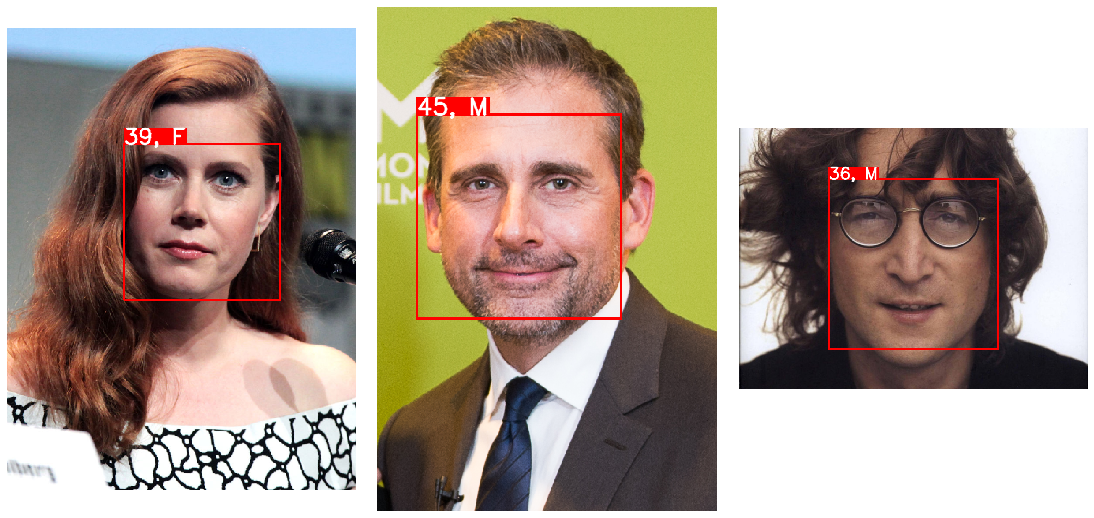

In [10]:
# https://github.com/yu4u/age-gender-estimation
# https://github.com/yu4u/age-gender-estimation/releases/download/v0.5/weights.29-3.76_utk.hdf5
# serialize model to JSON
# https://github.com/thegopieffect/computer_vision
# https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/
# https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE
# https://susanqq.github.io/UTKFace/
# https://stackoverflow.com/questions/53859419/dlib-get-frontal-face-detector-gets-faces-in-full-image-but-does-not-get-in-c

import sys
import numpy as np
from keras.models import Model
from keras import backend as K
import cv2
import dlib
from keras.models import model_from_json
from glob import glob
import matplotlib.pylab as plt

#sys.setrecursionlimit(2 ** 20)
#np.random.seed(2 ** 10)

depth = 16
k = width = 8
margin = 0.4
img_size = 64
#conf_threshold = 0.5

#! pip install dlib
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1, thickness=2):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)

json_file = open('models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('models/weights.29-3.76_utk.hdf5') #weights.28-3.73.hdf5')
# for face detection
detector = dlib.get_frontal_face_detector()

plt.figure(figsize=(15,7))
plt.subplots_adjust(0,0,1,1,0.05,0.05)
j = 1
for img_file in glob('images/celeba/*.jpg'): #['images/all.png']: 
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = np.shape(img)
    r = 640 / max(img_h, img_w)
    img = cv2.resize(img, (int(img_w * r), int(img_h * r)))

    # detect faces using dlib detector
    detected = detector(img, 0) #0)

    faces = np.empty((len(detected), img_size, img_size, 3))
    
    if len(detected) > 0:
        for i, d in enumerate(detected):
            x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
            xw1 = max(int(x1 - margin * w), 0)
            yw1 = max(int(y1 - margin * h), 0)
            xw2 = min(int(x2 + margin * w), img_w - 1)
            yw2 = min(int(y2 + margin * h), img_h - 1)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            faces[i, :, :, :] = cv2.resize(img[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))

        # predict ages and genders of the detected faces
        results = loaded_model.predict(faces)
        predicted_genders = results[0]
        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results[1].dot(ages).flatten()
        print(predicted_ages)

        # draw results
        for i, d in enumerate(detected):
            label = "{}, {}".format(int(predicted_ages[i]), "F" if predicted_genders[i][0] > 0.5 else "M")
            draw_label(img, (d.left(), d.top()), label)

    plt.subplot(1,3,j), plt.imshow(img), plt.axis('off')
    j += 1
plt.show()

In [65]:
#open shot FD
#model_json = model.to_json()
#with open("models/model.json", "w") as json_file:
#    json_file.write(model_json)
#net = cv2.dnn.readNetFromCaffe('models/deploy.prototxt.txt', 'models/res10_300x300_ssd_iter_140000.caffemodel')
#width, height = 300, 300
#blob = cv2.dnn.blobFromImage(img, 1.0, (width, height), [104, 117, 123], False, False)
#net.setInput(blob)
#detections = net.forward()
#detected = detections.shape[2]
#for i in range(detections.shape[2]):
#    confidence = detections[0, 0, i, 2]
#    if confidence > conf_threshold:
#        x1 = int(detections[0, 0, i, 3] * width)
#        y1 = int(detections[0, 0, i, 4] * height)
#        x2 = int(detections[0, 0, i, 5] * width)
#        y2 = int(detections[0, 0, i, 6] * height)
#        xw1 = max(int(x1 - margin * w), 0)
#        yw1 = max(int(y1 - margin * h), 0)
#        xw2 = min(int(x2 + margin * w), img_w - 1)
#        yw2 = min(int(y2 + margin * h), img_h - 1)  